In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import scipy.sparse as sparse
import random
import implicit
from implicit.als import AlternatingLeastSquares as ALS

%cd /home/user_3/medistream-recsys/Script
from preprocessing import drop_columns,dict_to_column,dict_to_set,set_to_column,key_to_element

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 100)

/home/user_3/medistream-recsys/Script


# Load Data

In [2]:
df = pd.read_json('/fastcampus-data/select_column_version_4.json')
df

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
0,5d60cebb4e77525ec5ca141c,None,NaN,NaN,NaN,None,5d60cea34e77525ec5ca1413,False,None,None,None,NaN,NaN,NaN,20-29,1.0,0.0,False,None,None
1,5d60daf14e77525ec5ca1497,2019-08-21T05:04:55.728Z,66000.0,0.0,NaN,None,5d60ceba4e77525ec5ca1419,False,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,3.0,59400.0,178200.0,20-29,1.0,0.0,True,의약품,medicine
2,5d60d2d04e77525ec5ca145b,2019-08-21T05:04:55.728Z,66000.0,0.0,NaN,2019-09-06T09:13:26.749Z,5d60d0a94e77525ec5ca1446,True,제일 경옥고,5cf8bbba0098b2225c5dfaa2,5d5cd0f74e77525ec5ca12ab,1.0,59400.0,59400.0,30-39,0.0,1.0,False,의약품,medicine
3,5d60e27c4e77525ec5ca14b6,2019-10-16T04:03:00.777Z,44800.0,37900.0,0.0,2019-10-21T02:18:23.528Z,5d60e2694e77525ec5ca14b5,True,"한의원 원장님도 기획자가 돼야한다 생각한다면, 읽어야 하는 책",5cf8bbba0098b2225c5dfaa3,5da696740dabe405b156eb5c,1.0,37000.0,37000.0,20-29,0.0,0.0,False,도서,book
4,5d60f8764e77525ec5ca14e5,None,NaN,NaN,NaN,None,5d60f3a74e77525ec5ca14da,False,None,None,None,NaN,NaN,NaN,40-49,1.0,1.0,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266653,632044cb6c2e37002369f129,2022-02-16T04:01:35.033Z,41500.0,35200.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 황기(편) (5묶음) 600g*5ea, 중국",5fb32f7a5120316334323fd8,620c771fd41623002392d61b,1.0,35200.0,35200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266654,632044cb6c2e37002369f129,2020-11-20T06:59:35.395Z,4900.0,4200.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 어성초 600g, 중국",5fb32f7a5120316334323fd8,5fb769575120316334324a69,1.0,4200.0,4200.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266655,632044cb6c2e37002369f129,2020-11-20T06:59:36.047Z,3900.0,3300.0,NaN,2022-09-13T08:53:42.268Z,5d918f180dabe405b156d5e5,True,"[씨케이주식회사] 여정실 600g, 중국",5fb32f7a5120316334323fd8,5fb769585120316334324a6a,1.0,3300.0,3300.0,30-39,0.0,1.0,False,한약재,medicinal-herbs
266656,632045696c2e37002369f136,2022-08-30T00:42:13.239Z,330000.0,0.0,386.0,2022-09-13T08:59:21.151Z,628ecb419d9388002406f007,True,맘 편하게 한약 처방하기,5ea40b671a3ca36b967849ad,630d5ce568554000236d9a5d,1.0,264000.0,264000.0,None,1.0,0.0,False,온라인 강의,lecture


# 전처리


In [3]:
date_state = "2022-05-12"

# paid orders만 가져오기
df['date_paid'] = pd.to_datetime(df['date_paid'])
df_only_paid = df[~df['date_paid'].isna()]
# 3개월치 데이터만 가져오기
df_date = df_only_paid[df_only_paid['date_paid'] > date_state]
# 취소 안된 것만 가져오기
complete_df = df_date[(df_date['paid'] == True) & (df_date['cancelled']==False)]
# 도서 카테고리만 가져오기
only_book = complete_df[complete_df['name'] == '도서']

# 유저가 중복으로 아이템 구매 삭제
df_duplicated_book = only_book.drop_duplicates(subset=['customer_id','product_ids'])
df_book = df_duplicated_book.sort_values(by='date_paid').reset_index(drop=True)


In [4]:
from datetime import datetime, timedelta

date = df_book['date_paid'].max()-timedelta(weeks=3)
train = df_book[df_book['date_paid'] < date]
test = df_book[df_book['date_paid'] >= date]

In [5]:
test.shape

(886, 20)

In [6]:
test.head()

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
5024,6304945a58e1680033a58311,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 08:52:17+00:00,629f0f809d93880024072c21,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,None,1.0,1.0,False,도서,book
5025,630494eb58e1680033a58339,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 08:52:23.718000+00:00,5de0fcc22bb59605ca3d0bee,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,20-29,1.0,0.0,False,도서,book
5026,6304936158e1680033a582bb,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 08:52:40+00:00,5e068e694267e105dfff01bc,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,40-49,1.0,0.0,False,도서,book
5027,6304954e58e1680033a58344,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 08:53:09.306000+00:00,5e7545adbfe4260944783da2,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,40-49,1.0,1.0,False,도서,book
5028,6304956558e1680033a5834b,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 08:53:18.490000+00:00,5d69cd4319efa30eb2913de3,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,30-39,0.0,1.0,False,도서,book


# Test데이터와 Train 데이터 비교

## 가정 : Train 기간과 Test 기간의 베스트 셀러가 같을 것이다
-> 기각 train의 베스트 셀러와 Test기간의 베스트셀러는 같다고 보기 힘들다.

In [7]:
train_bestseller = train['name_x'].value_counts().to_frame().reset_index().rename(columns={'index':'name','name_x':'count'}).head(10)
train_bestseller

,name,count
0,비만문답,574
1,플로차트 정형외과 진단,447
2,흔히보는 정형외과 외래진료 가이드북,313
3,윤상훈·권병조의 알짜 근육학,222
4,황황교수의 임상의를 위한 근거기반 상한금궤 처방 매뉴얼,213
5,황황교수의 개원 한의사를 위한 상한금궤 처방 강의록,197
6,외래에서 꼭 알아야 할 통증증후군 137가지,143
7,카이로프랙틱 기본테크닉론,133
8,사암침의 해석과 임상,125
9,약침의 정석 –통증편,101


In [8]:
test_bestseller = test['name_x'].value_counts().to_frame().reset_index().rename(columns={'index':'name','name_x':'count'}).head(10)
test_bestseller

,name,count
0,초음파 유도하 침 시술 가이드북,268
1,영어 진료 가이드북,225
2,소아피부질환해설,49
3,윤상훈·권병조의 알짜 근육학,27
4,비만문답,18
5,임상 한의사를 위한 기본 한약처방 강의 2판,16
6,플로차트 정형외과 진단,14
7,사상방 사용설명서,13
8,일차진료 한의사를 위한 보험한약입문 - 둘째 판,9
9,한의 피부진료 첫 걸음,8


In [9]:
test_bestseller2 = test['product_ids'].value_counts().to_frame().reset_index().rename(columns={'index':'name','name_x':'count'}).head(10)
test_bestseller2

,name,product_ids
0,62ff2f43ca740b0024397ca4,268
1,63046e9358e1680033a580d6,225
2,5e4215f84267e105dfff17b9,49
3,60d018b7d26af90681b18980,27
4,629860599d93880024071acc,18
5,610b6f9ad26af90681b1e699,16
6,62bbee3a08e04900234e36c8,14
7,5f6860f348060c52caf14690,13
8,5d59ee854e77525ec5ca1212,9
9,5dedb5e04267e105dffeef43,8


### train_test 양쪽 베스트 셀러인 책

In [10]:
train_test_bestseller = train_bestseller[train_bestseller['name'].isin(test_bestseller['name'])]
test_train_bestseller = test_bestseller[test_bestseller.name.isin(train_test_bestseller.name)]
test_train_bestseller

,name,count
3,윤상훈·권병조의 알짜 근육학,27
4,비만문답,18
6,플로차트 정형외과 진단,14


In [11]:
train_test_bestseller['count'].sum() / train['name_x'].value_counts().sum()

0.2474124203821656

In [12]:
test_train_bestseller['count'].sum() / test['name_x'].value_counts().sum()

0.06659142212189616

### test기간 bestseller의 train기간 판매 비율

In [13]:
train[train['name_x']=='초음파 유도하 침 시술 가이드북']

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug
4932,630441f858e1680033a57f98,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 02:57:55.061000+00:00,5de1b5ae2bb59605ca3d0c0b,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,30-39,1.0,0.0,False,도서,book
4933,630443a958e1680033a57fa4,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:09:07+00:00,5d8349e33f0e6805c47067ea,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,None,1.0,1.0,False,도서,book
4934,63044a5858e1680033a57fe6,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:37:41+00:00,5d73a77619efa30eb291437c,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,20-29,1.0,0.0,False,도서,book
4935,63044cae58e1680033a57fff,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:43:11.940000+00:00,5dc428b42bb59605ca3cf912,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,30-39,0.0,1.0,False,도서,book
4936,63044c8158e1680033a57ffd,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:43:33.944000+00:00,5dbb891a2bb59605ca3cf4b5,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,20-29,1.0,0.0,False,도서,book
4937,63044cea58e1680033a58002,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:44:04.711000+00:00,610117d1d26af90681b1d866,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,40-49,1.0,1.0,False,도서,book
4938,63044b1058e1680033a57fee,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 03:55:20.001000+00:00,5d73639f19efa30eb2914376,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,30-39,1.0,1.0,False,도서,book
4939,6304565f58e1680033a5802f,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 04:30:49+00:00,5d60cd414e77525ec5ca1401,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,30-39,1.0,1.0,False,도서,book
4940,63045bce58e1680033a58041,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 04:47:47.313000+00:00,6036403d643a8a0019f2aee1,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,20-29,1.0,0.0,False,도서,book
4942,63045f3d58e1680033a5805c,2022-08-19T06:35:47.781Z,35000.0,31500.0,354.0,2022-08-23 05:02:58.654000+00:00,5d96fd400dabe405b156dbe2,True,초음파 유도하 침 시술 가이드북,5cf8bbba0098b2225c5dfaa3,62ff2f43ca740b0024397ca4,1.0,31500.0,31500.0,20-29,1.0,0.0,False,도서,book


In [14]:
test[test['name_x'] == '영어 진료 가이드 북']

,_id,date_created,regular_price,sale_price,three_months,date_paid,customer_id,paid,name_x,category_id_y,product_ids,quantity,price,price_total,age_group,한의사 여부,사업자 여부,cancelled,name,slug


# 상위 2개 책의 비율

In [15]:
len(test[ (test['product_ids']=='62ff2f43ca740b0024397ca4') | (test['product_ids']=='63046e9358e1680033a580d6') ])/len(test)

0.5564334085778782

# 일자별 책의 판매량 데이터가 이상하다? 
-> 추론:잘팔리는 책은 강의와 상관있는 책일 것이다.

In [16]:
test['date_paid'] = test['date_paid'].dt.strftime('%m/%d/%Y')

<ipython-input-16-91ea6a5524da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date_paid'] = test['date_paid'].dt.strftime('%m/%d/%Y')


In [17]:
test['date_paid'].value_counts()

09/01/2022    131
08/30/2022    127
09/08/2022     99
08/23/2022     96
08/31/2022     66
09/06/2022     58
08/26/2022     38
09/02/2022     37
09/07/2022     33
08/24/2022     30
09/05/2022     25
08/25/2022     22
09/04/2022     20
08/27/2022     18
08/28/2022     17
09/13/2022     16
09/12/2022     15
08/29/2022     14
09/03/2022     12
09/09/2022      6
09/11/2022      4
09/10/2022      2
Name: date_paid, dtype: int64

In [20]:
test_pivot = test.pivot_table('quantity','name_x','date_paid',aggfunc='sum',margins=True).sort_values(by='All',ascending=False)
test_pivot

date_paid,08/23/2022,08/24/2022,08/25/2022,08/26/2022,08/27/2022,08/28/2022,08/29/2022,08/30/2022,08/31/2022,09/01/2022,09/02/2022,09/03/2022,09/04/2022,09/05/2022,09/06/2022,09/07/2022,09/08/2022,09/09/2022,09/10/2022,09/11/2022,09/12/2022,09/13/2022,All
name_x,,,,,,,,,,,,,,,,,,,,,,,
All,96.0,30.0,22.0,57.0,20.0,17.0,16.0,129.0,66.0,137.0,39.0,12.0,20.0,25.0,58.0,34.0,99.0,6.0,2.0,4.0,15.0,17.0,921.0
초음파 유도하 침 시술 가이드북,92.0,23.0,11.0,38.0,13.0,4.0,4.0,14.0,18.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,293.0
영어 진료 가이드북,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95.0,25.0,20.0,4.0,2.0,2.0,4.0,6.0,5.0,64.0,NaN,NaN,NaN,NaN,NaN,227.0
소아피부질환해설,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.0,5.0,2.0,NaN,NaN,NaN,2.0,2.0,49.0
윤상훈·권병조의 알짜 근육학,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,2.0,3.0,1.0,2.0,NaN,3.0,1.0,2.0,5.0,NaN,NaN,1.0,1.0,3.0,28.0
비만문답,NaN,NaN,NaN,1.0,NaN,1.0,1.0,1.0,2.0,2.0,NaN,1.0,NaN,2.0,2.0,1.0,1.0,NaN,NaN,1.0,2.0,NaN,18.0
임상 한의사를 위한 기본 한약처방 강의 2판,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,2.0,NaN,3.0,2.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,2.0,16.0
플로차트 정형외과 진단,1.0,1.0,2.0,1.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,2.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,14.0
사상방 사용설명서,1.0,NaN,1.0,1.0,NaN,NaN,NaN,3.0,NaN,NaN,2.0,1.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,13.0


<AxesSubplot:xlabel='date_paid', ylabel='name_x'>

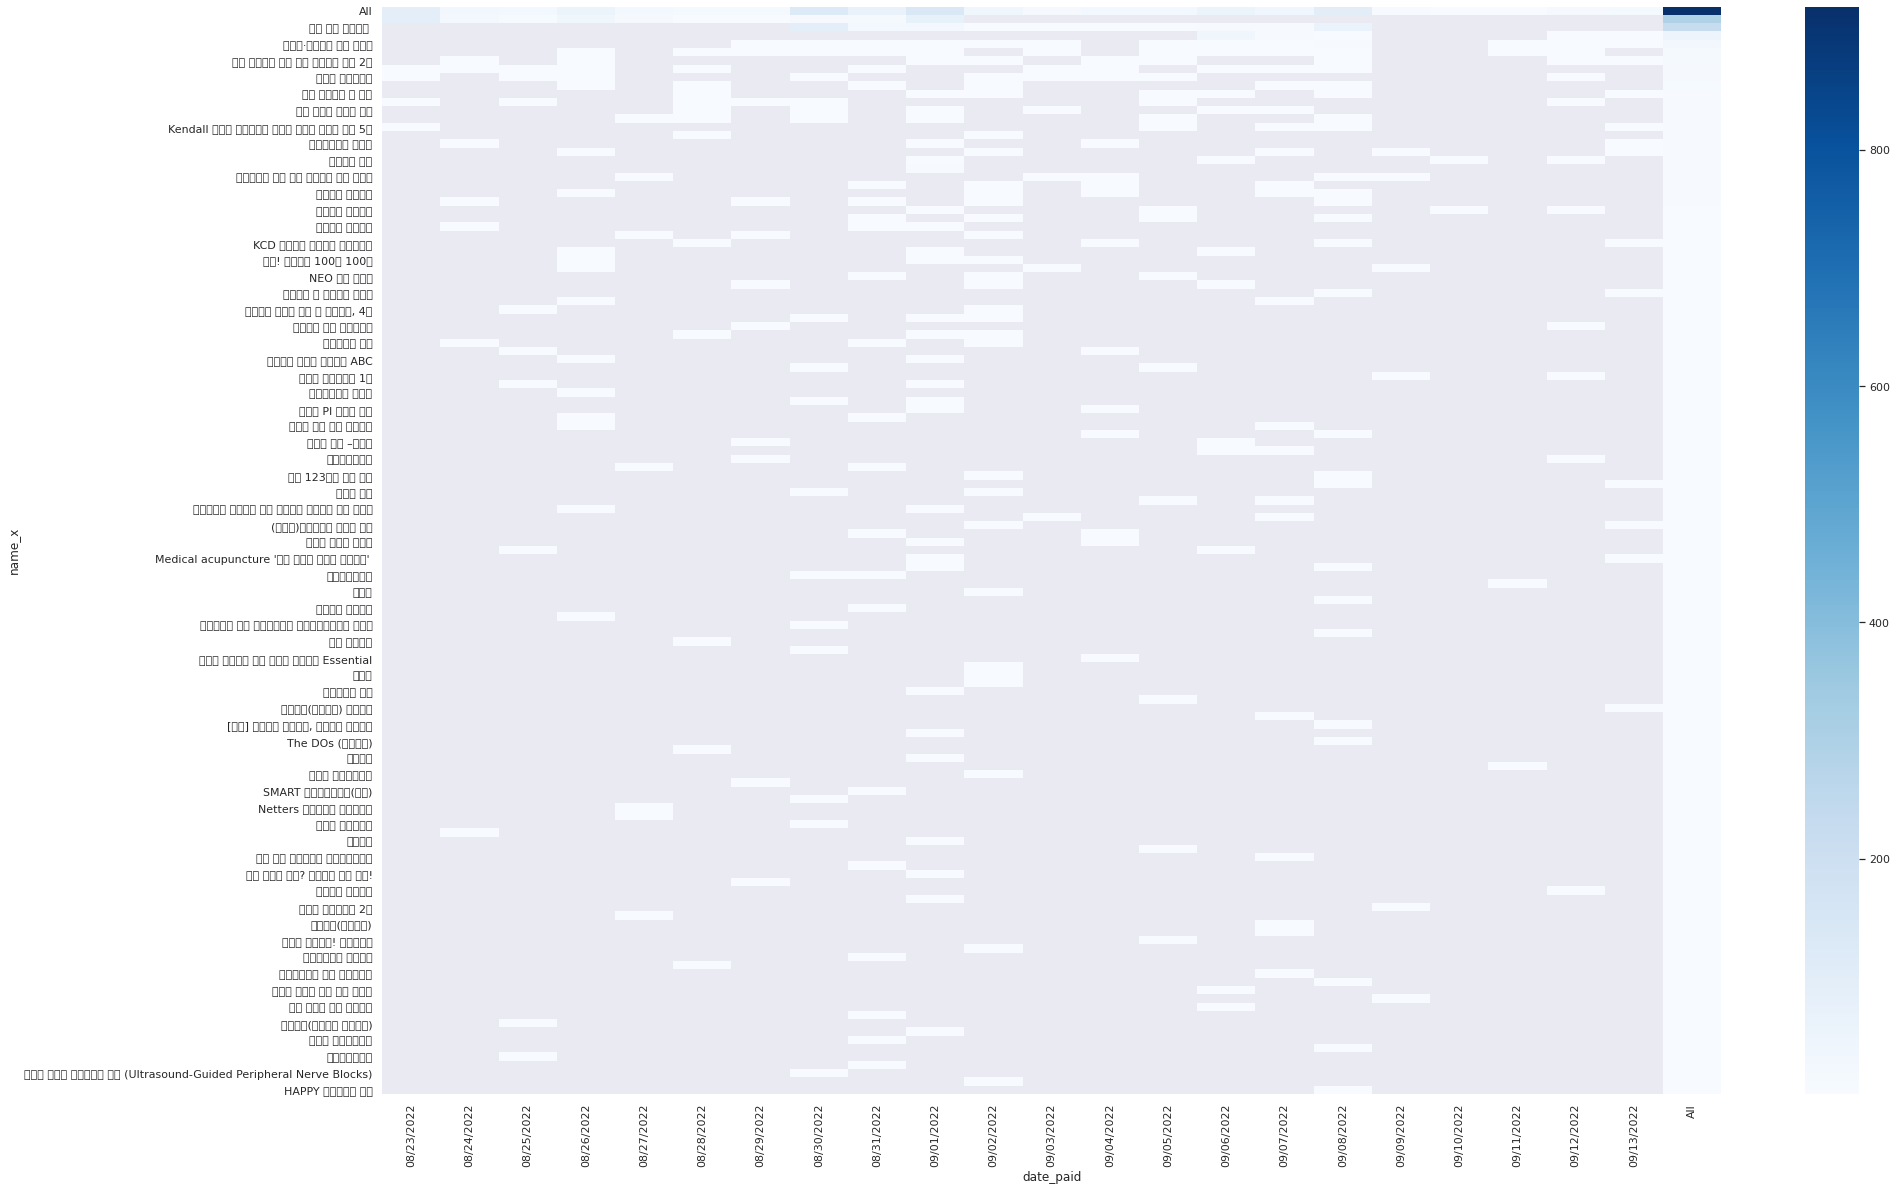

In [25]:
test_pivot
sns.set(rc={'figure.figsize':(15, 5)})
plt.figure(figsize=(30,20))
sns.heatmap(test_pivot,cmap="Blues")

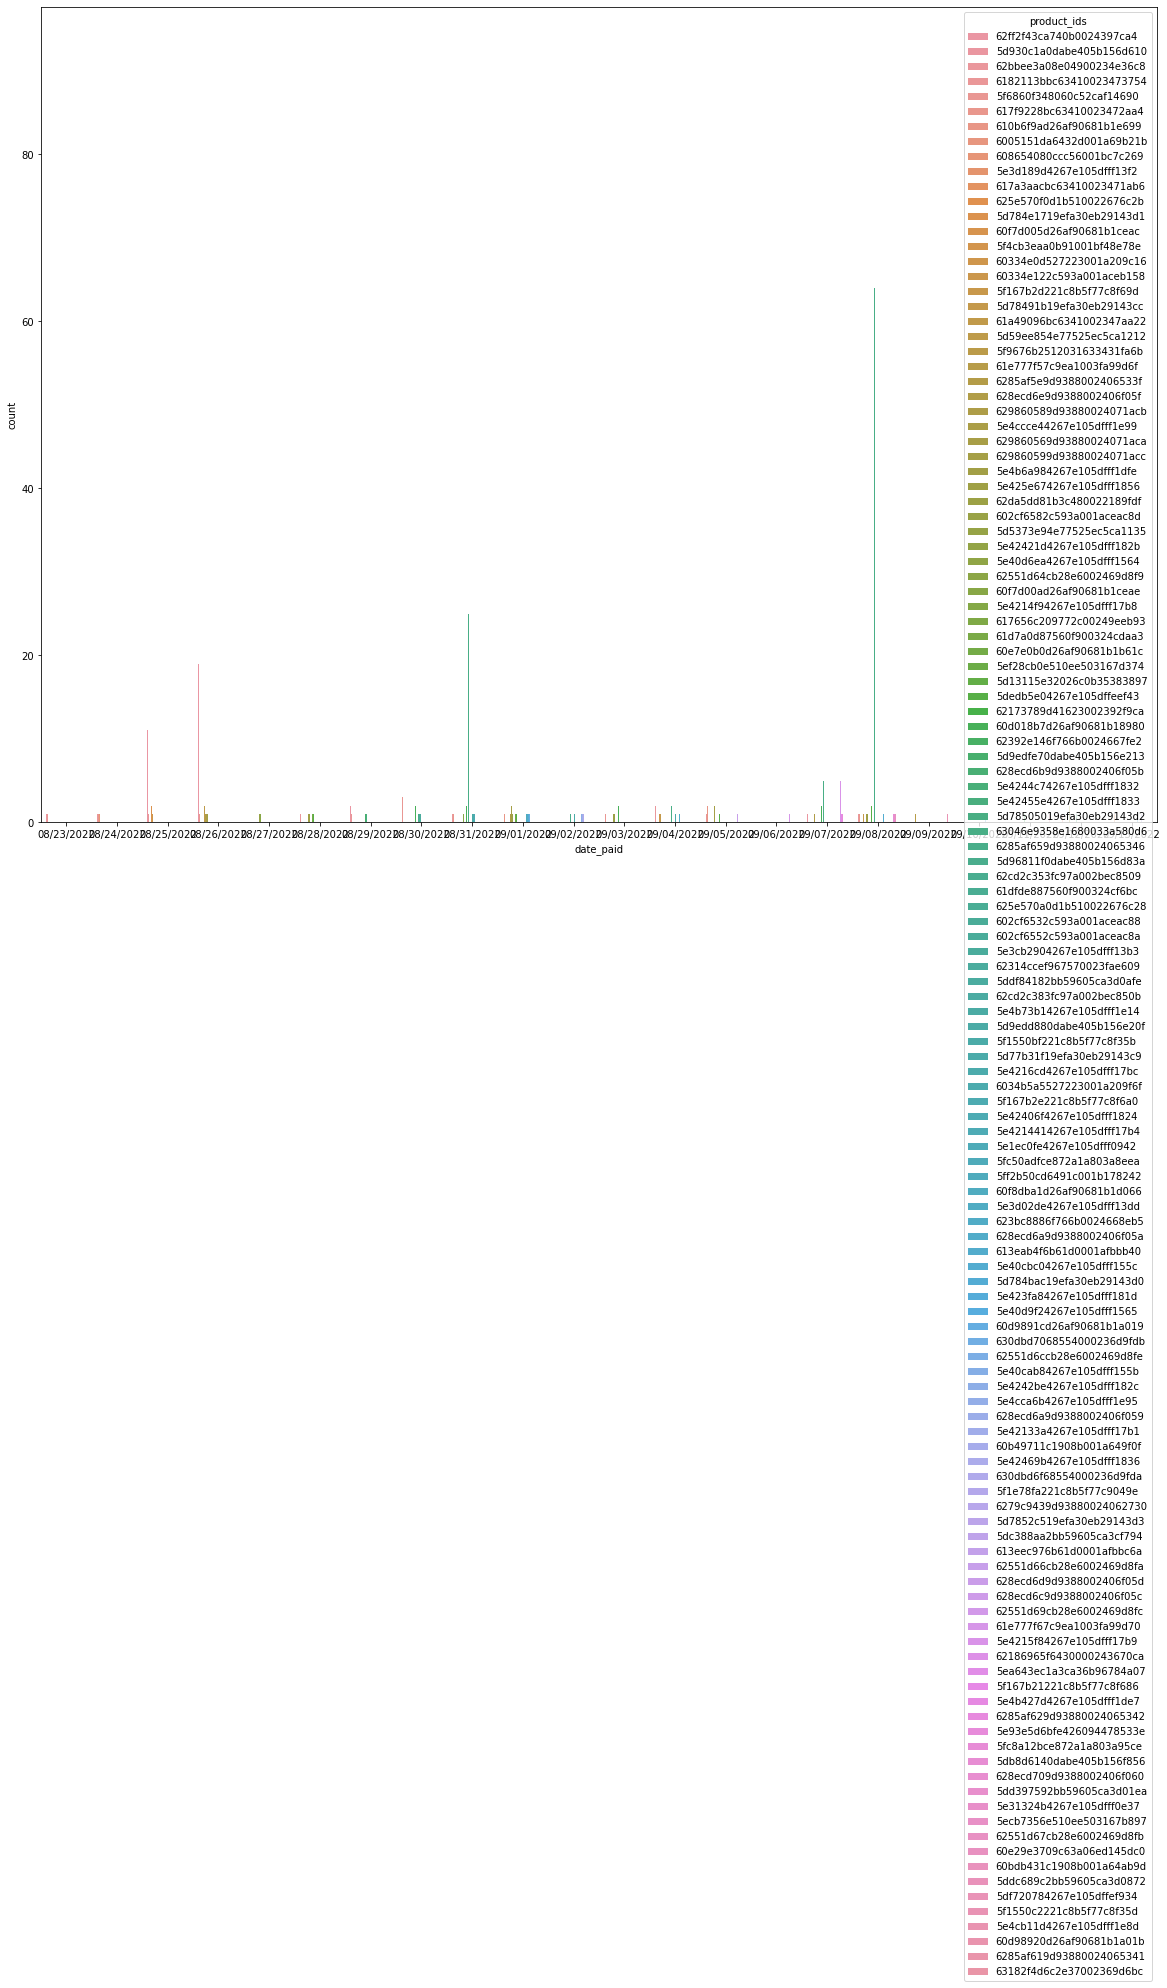

In [19]:
plt.figure(figsize=(20,15))
sns.countplot(data=test,x='date_paid',hue='product_ids')
plt.show()

## 이상치 확인

In [22]:
test[test['product_ids']=='62ff2f43ca740b0024397ca4'].loc[:,'한의사 여부':'사업자 여부']

,한의사 여부,사업자 여부
5024,1.0,1.0
5025,1.0,0.0
5026,1.0,0.0
5027,1.0,1.0
5028,0.0,1.0
5029,1.0,0.0
5030,1.0,1.0
5031,1.0,1.0
5032,1.0,1.0
5033,1.0,1.0


In [23]:
# 한의사 비율
test[test['product_ids']=='62ff2f43ca740b0024397ca4']['한의사 여부'].sum() / len(test[test['product_ids']=='62ff2f43ca740b0024397ca4'])

0.8134328358208955

In [24]:
# 사업자 비율
test[test['product_ids']=='62ff2f43ca740b0024397ca4']['사업자 여부'].sum() / len(test[test['product_ids']=='62ff2f43ca740b0024397ca4'])

0.4962686567164179

한의사를 대상으로 하는 강의가 있었던 것이 아닌가 생각된다.

## log에서 확인해보자
chunk로 열다가 서버 터질뻔함

In [27]:
filename = '/fastcampus-data/log-data/csv_seg_all.csv'
chunksize = 10 ** 6

df_list = []
with pd.read_csv(filename, chunksize=chunksize) as reader:
    for chunk in tqdm(reader):
        df_list.append(chunk)
    df_log = pd.concat(df_list)

df_log = df_log.reset_index(drop=True )

0it [00:00, ?it/s]/home/user_1/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (3,14,17,19) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
4it [00:32,  8.18s/it]


In [28]:
df_log

,context_page_path,context_page_referrer,context_page_search,context_page_search_keyword,context_page_search_borad,context_page_search_type,context_page_title,context_page_url,context_useragent,messageid,timestamp,yw,ym,ymd,properties_url,type,userid,traits_customerid,name,event,partition_0,partition_1
0,/articles/48660,https://medistream.co.kr/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr,Mozilla/5.0 (Linux; Android 12; SM-G986N Build...,ajs-next-e749b4f3d03fbb1e3d14f64c3ff0d2e2,2022-05-25 06:16:22.082,2022-21,2022-05,2022-05-25,NaN,page,69a7acf83df42d81480d78d2ca6f2ee05303624bc7be19...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1653350400000
1,/articles/48671,https://medistream.co.kr/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr,Mozilla/5.0 (Linux; Android 12; SM-S908N) Appl...,ajs-next-f99e8d0d8a815b37825cd8d9dd46eaed,2022-05-25 06:49:11.338,2022-21,2022-05,2022-05-25,NaN,page,55584fbe7fe9b94a5afc3de7e95d4db38543e7fb41a192...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1653350400000
2,/articles/48074,NaN,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr,Mozilla/5.0 (Linux; Android 12; SM-F711N Build...,ajs-next-6a88ca015159817e90ca153f468a72d1,2022-05-25 07:01:42.390,2022-21,2022-05,2022-05-25,NaN,page,26438acbb9f2154ed0595b55cd961305edfa5d6da78acb...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1653350400000
3,/articles/48811,https://medistream.co.kr/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr,Mozilla/5.0 (Linux; Android 12; SM-G973N) Appl...,ajs-next-66c4c926f113fb4a9c01272d65bb710d,2022-05-24 19:12:15.326,2022-21,2022-05,2022-05-24,NaN,page,3bc249c5607e7a3e1da6c4156931038035490ee25647d3...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1653350400000
4,/articles/48795,https://medistream.co.kr/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,ajs-next-4a5af6d2a9db2a896d77f3419679dd11,2022-05-24 19:14:18.855,2022-21,2022-05,2022-05-24,NaN,page,2cac9d7170caf052438730bd2c2294524f3ab45b92230c...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1653350400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568761,/articles/new,https://medistream.co.kr/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr/articles/new,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,ajs-next-8efda5ff2e1100b7466ce0836fee779f,2022-09-13 09:18:49.564,2022-37,2022-09,2022-09-13,NaN,page,d63a1f1da4384bf48b4a48502bbf68a860a571fb56c0c1...,NaN,ArticlesNew,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1663027200000
3568762,/articles/54491,https://medistream.co.kr/,{},NaN,NaN,NaN,(1) 메디스트림 | Medistream,https://medistream.co.kr/boards/KMDForest,Mozilla/5.0 (Linux; Android 12; SM-S908N) Appl...,ajs-next-1318839fef5a0ec5e1bb5d16efd0a309,2022-09-13 09:25:43.482,2022-37,2022-09,2022-09-13,NaN,page,1cd6ae240920b8d70bbf3b70290754c07f2639912020e4...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1663027200000
3568763,/market/categories/book,NaN,{},NaN,NaN,NaN,(17) 메디스트림 | Medistream,https://medistream.co.kr/market?sort=three_mon...,Mozilla/5.0 (Linux; Android 12; SM-A235N Build...,ajs-next-fa6ec9da642ded521540666c9d6e8ffc,2022-09-13 09:27:43.840,2022-37,2022-09,2022-09-13,NaN,page,b38d2f78bab875b41e9ef4a1f54edab5ea6fb059196ff7...,NaN,MarketCategoriesMedicinalHerbs,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1663027200000
3568764,/articles/54508,NaN,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr/boards/KMDForest,Mozilla/5.0 (iPhone; CPU iPhone OS 15_6_1 like...,ajs-next-a4d3c48171a5f40d8db543aad2d097bf,2022-09-13 09:46:31.558,2022-37,2022-09,2022-09-13,NaN,page,270824b2da74eaac8995a5766956f73b9701b7dc40ca50...,NaN,ArticlesArticle,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1663027200000


In [65]:
df_log[df_log['context_page_url'].str.contains('62ff2f43ca740b0024397ca4')]

,context_page_path,context_page_referrer,context_page_search,context_page_search_keyword,context_page_search_borad,context_page_search_type,context_page_title,context_page_url,context_useragent,messageid,timestamp,yw,ym,ymd,properties_url,type,userid,traits_customerid,name,event,partition_0,partition_1
3522750,/market/categories/book,https://nid.naver.com/,{},NaN,NaN,NaN,메디스트림 | Medistream,https://medistream.co.kr/products/62ff2f43ca74...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,ajs-next-0c72b6c62551a2611c89c3635af66223,2022-08-26 14:22:14.188,2022-34,2022-08,2022-08-26,NaN,page,e5fd2d692e2b77ac050b8b9d1880b02f5eeb011bc776ea...,NaN,MarketCategoriesCategory,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1661472000000
3535947,/market/categories/book,https://medistream.co.kr/,{},NaN,NaN,NaN,(4) 메디스트림 | Medistream,https://medistream.co.kr/products/62ff2f43ca74...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,ajs-next-e1e7722f1f2b5999505db8ede58f3b64,2022-08-26 09:49:30.243,2022-34,2022-08,2022-08-26,NaN,page,d63a1f1da4384bf48b4a48502bbf68a860a571fb56c0c1...,NaN,MarketCategoriesCategory,NaN,pAzAoFnKNpLfHxRmZ2oDF4,1661472000000
